## 1. Imports

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

from load_data import train_ds, val_ds, test_ds

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [4]:
#determine the number of classes
for _, labels in train_ds:
    num_classes = len(labels[0])
    break

## 2. Create a base case that needs to be surpassed

In [5]:
def random_classifier(dataset, num_classes):
    random_predictions = []
    true_labels = []
    
    for _, labels in dataset:
        batch_size = labels.shape[0]
        random_preds = np.random.randint(0, num_classes, size=batch_size)
        random_predictions.extend(random_preds)
        
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    return np.array(random_predictions), np.array(true_labels)

In [6]:
from sklearn.metrics import accuracy_score

def evaluate_random_classifier(random_predictions, true_labels):
    accuracy = accuracy_score(true_labels, random_predictions)
    print(f'Random Classifier Accuracy: {accuracy * 100:.2f}%')

In [7]:
random_predictions, true_labels = random_classifier(train_ds, num_classes)
evaluate_random_classifier(random_predictions, true_labels)

Random Classifier Accuracy: 1.99%


## 3. Create a model

**I will use fine-tuning due to the small amount of computer power. Let's take the ConvNext model (Tiny version) as a basis, other high-quality options: Vit, swin, BEiT, EfficientNet. Then I will finish training the model on my data**

In [8]:
conv_base = keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    weights='imagenet',
    input_shape = (224, 224, 3)
)

In [34]:
x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=conv_base.input, 
                    outputs=outputs, 
                    name='cards_classification')

#Freeze the layers of the base model
for layer in conv_base.layers:
    layer.trainable = False

In [44]:
model.summary()

Model: "cards_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_prestem_normal… │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stem            │ (None, 56, 56, 96)        │           4,896 │ convnext_tiny_prestem_nor… │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │           4,800 │ convnext_tiny_stem[0][0]   │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │             192 │ convnext_tiny_stage_0_blo… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 384)       │          37,248 │ convnext_tiny_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 384)       │               0 │ convnext_tiny_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │          36,960 │ convnext_tiny_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │              96 │ convnext_tiny_stage_0_blo… │
│ (LayerScale)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │               0 │ convnext_tiny_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 56, 56, 96)        │               0 │ convnext_tiny_stem[0][0],  │
│                               │                           │                 │ convnext_tiny_stage_0_blo… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 56, 56, 96)        │           4,800 │ add[0][0]                  │
│ (Conv2D)                      │                           │               

 Total params: 28,030,613 (106.93 MB)

 Trainable params: 210,485 (822.21 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [35]:
from keras.optimizers import AdamW

#Use categorical_crossentropy, because the data was encoded using categorical label mode
#The reason for using a low learning rate is the need to limit the amount of changes made
#to the representations of the three pre-trained layers. Making too many changes can damage these views.
model.compile(
    loss="categorical_crossentropy",
    optimizer=AdamW(learning_rate=1e-4),
    metrics=["accuracy"]
)

In [36]:
from keras.callbacks import ModelCheckpoint

#use callbacks to save the model at the optimal point
callbacks = [
    ModelCheckpoint(
    filepath='cards_classification.keras',
    save_best_only=True,
    monitor='val_loss'
    )
]

## 4. Fit a model

In [33]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/100


KeyboardInterrupt: 

## 5. Visualization of learning

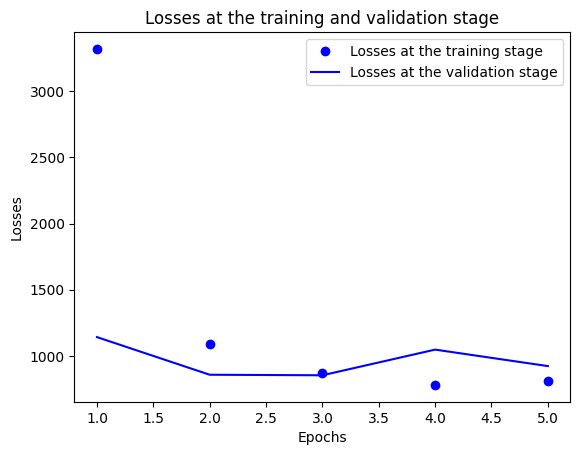

In [41]:
import matplotlib.pyplot as plt

#Graph of losses at the training and validation stage
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Losses at the training stage")
plt.plot(epochs, val_loss_values, "b", label="Losses at the validation stage")
plt.title("Losses at the training and validation stage")
plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.legend()
plt.show()

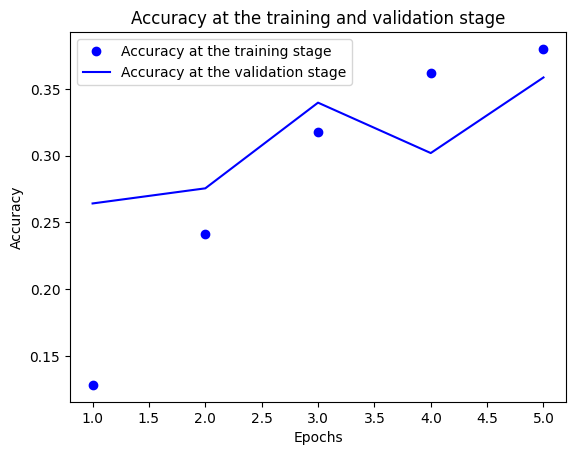

In [43]:
plt.clf() 

#Graph of accuracy at the training and validation stage
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Accuracy at the training stage")
plt.plot(epochs, val_acc, "b", label="Accuracy at the validation stage")
plt.title("Accuracy at the training and validation stage")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()